### San Lorenzo Stream Flow model

Draw on records of stream flow, rainfall, and ocean temperatures to predict future San Lorenzo flow on timescales ranging from hours to days to weeks. Goal is to use both machine-learning as well as variations on the linear reservoir model to predict the flow.

Additionally, the autocorrelated properties of the San Lorenzo flow appear reminiscent of (and may show quantifiable similarity to) volatity in the financial markets as measured, for example, by the CBOE VIX index.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime
import pytz

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#plt.style.use('fivethirtyeight')

# Forecasting
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster


#### SanLorenzoGageData.csv -- river-flow time series

The San Lorenzo Gage records the flow (in cubic feet per second) of the San Lorenzo River https://en.wikipedia.org/wiki/San_Lorenzo_River, which drains a relatively small watershed of size 138 square miles covering part of Santa Cruz County, California, before emptying into the Pacific Ocean at Santa Cruz. The data is hosted by the USGS and is available at https://waterdata.usgs.gov/usa/nwis/uv?site_no=11160500. 

For this analysis, import records of water flow measured in cubic feet per second at a location (associated with the foregoing USGS link) a short distance upstream from the river mouth. Once imported, the data should be sampled at a 15min cadence running from 2010-01-01 00:00 to 2022-06-29 09:30, corresponding to just under 4.4M total records (contained in the file sanLorenzoGageData.csv).

In [3]:
gageData=pd.read_csv('data/sanLorenzoGageData.csv', engine='python', sep='\t',skiprows=28)
gageData=gageData.drop([0])

gageData['Timestamp']=pd.to_datetime(gageData['datetime'].astype(str), infer_datetime_format=True)

pacific = pytz.timezone('US/Pacific')
gageData['Timestamp'] = gageData['Timestamp'].dt.tz_localize(pacific, ambiguous='NaT').dt.tz_convert(pytz.utc)
gageData=gageData.drop(['agency_cd', 'site_no', 'datetime', 'tz_cd'], axis=1)
gageData=gageData[pd.notnull(gageData['Timestamp'])]
gageData=gageData.rename(columns={'14696_00060': 'Flow', '14696_00060_cd': "status"}, errors="raise")
gageData['Flow']=gageData['Flow'].astype(float)
gageData=gageData.sort_values('Timestamp')


#### HourlyRainfall.csv -- local weather data in the watershed sampled at a two-hour cadence

Second data set currently consists of weather station records sampled at a location in Santa Cruz. The weather data (provided by USDA) includes hourly rainfall totals for hours sampled every other hour. The USDA-curated weather data also contains other variables (wind speed, soil temperature, solar irradiation) that can be explored for predictive influence.

In [4]:
rainfall=pd.read_csv('data/hourlyRainfall.csv')
rainfall=rainfall.dropna()
rainfall['Timestamp']=pd.to_datetime(rainfall['Date'].astype(str) + ' ' + rainfall['Hour (PST)'].astype(str), format="%m/%d/%Y %H%M")
pacific = pytz.timezone('US/Pacific')
rainfall['Timestamp'] = rainfall['Timestamp'].dt.tz_localize(pacific).dt.tz_convert(pytz.utc)
rainfall=rainfall.sort_values('Timestamp')
rainfall=rainfall.drop(['Date', 'CIMIS Region','Hour (PST)','Stn Id','Stn Name','Jul','qc','qc.1','qc.2','qc.3','qc.4','qc.5','qc.6','qc.7','qc.8','qc.9'], axis=1)
rainfall=rainfall.rename(columns={'Precip (mm)': 'Precip'}, errors="raise")
rainfall['Precip']=rainfall['Precip'].astype(float)

In [5]:
rainfall.columns

Index(['ETo (mm)', 'Precip', 'Sol Rad (W/sq.m)', 'Vap Pres (kPa)',
       'Air Temp (C)', 'Rel Hum (%)', 'Dew Point (C)', 'Wind Speed (m/s)',
       'Wind Dir (0-360)', 'Soil Temp (C)', 'Timestamp'],
      dtype='object')

Text(0, 0.5, '# hour intervals observed')

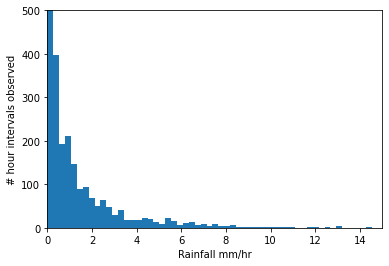

In [6]:
plt.hist(rainfall['Precip'].values,bins=np.linspace(0,np.max(rainfall['Precip'].values),num=100))
plt.xlim(0,15)
plt.ylim(0,500)
plt.xlabel('Rainfall mm/hr')
plt.ylabel('# hour intervals observed')

#### SouthernOscillationIndex.csv -- a global phenomenon that may have long-period influence on streamflows

A third data set, culled from NOAA records, is the *Southern Oscillation Index* https://www.ncei.noaa.gov/access/monitoring/enso/soi (SOI). As explained at the NOAA site, the SOI index is based on the observed sea level pressure differences between Tahiti and Australia. The SOI charts large-scale fluctuations in air pressure occurring between the western and eastern tropical Pacific during the so-called El Niño and La Niña episodes (according to the NOAA website, "the anomalies are departures from the 1981-2010 base period"). 

Smoothed time series of the SOI correlate with changes in ocean temperatures across the eastern tropical Pacific. Prolonged periods of negative (positive) SOI values coincide with abnormally warm (cold) ocean waters across the eastern tropical Pacific typical of El Niño (La Niña) episodes. These episodes, in turn, have influence on the duration, frequency, and intensity of rainfall in California, and may be of value as predictors over longer horizons.

In [9]:
df=pd.read_csv('data/SouthernOscillationIndex.csv', sep=' ', skipfooter=1, engine='python', skiprows=3, skipinitialspace=True)
data=df.iloc[:71 , 1:-1].values.flatten()

#71 is to grab the anomaly table from the dataFrame
yearList=df.iloc[0:71,0].values
monthList=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dayList=['15']
timeList=[]
#usage: datetime.strptime('1951 Jan 15',"%Y %b %d")
for year in yearList:
    for month in monthList:
        for day in dayList:
            dateString=year+' '+month+' '+day
            timeList.append(datetime.strptime(dateString,"%Y %b %d"))
            
SOI = pd.DataFrame({'Timestamp':timeList, 'SOIanomaly':data})
SOI['Timestamp']=SOI['Timestamp'].dt.tz_localize(pytz.utc)
SOI['SOIanomaly']=SOI['SOIanomaly'].astype(float)
SOI=SOI.sort_values('Timestamp')

#### Characterize

Read, wrangle and merge the three data sets to create a joint dataFrame that contains up-to-date value of the most recent rainfall rate measurement and the most recent measurement of the Southern Oscillation Index at the time of *each* San Lorenzo Gage streamflow measurement. 

In [10]:
gageData=pd.merge_asof(gageData,SOI,on='Timestamp')
gageData=gageData.dropna()
gageData=pd.merge_asof(gageData,rainfall,on='Timestamp')
gageData=gageData.dropna()
gageData=gageData.sort_values('Timestamp')
print(len(gageData),'records of streamflow and exogenous measurements (including rain rate and the SOI index)')

436865 records of streamflow and exogenous measurements (including rain rate and the SOI index)


Carry out some exploratory analysis of the joint data set. With a size verging on a half-million records, the streamflow dataset is somewhat large for interactive exploration and plotting. Downsample the data to daily cadence for an initial assessment.

In [11]:
gageData = gageData.set_index('Timestamp')
gageDataDaily=gageData.resample('D').ffill().dropna()
gageDataDaily.columns

Index(['Flow', 'status', 'SOIanomaly', 'ETo (mm)', 'Precip',
       'Sol Rad (W/sq.m)', 'Vap Pres (kPa)', 'Air Temp (C)', 'Rel Hum (%)',
       'Dew Point (C)', 'Wind Speed (m/s)', 'Wind Dir (0-360)',
       'Soil Temp (C)'],
      dtype='object')

Text(0, 0.5, 'log10(Flow in ft^3/sec)')

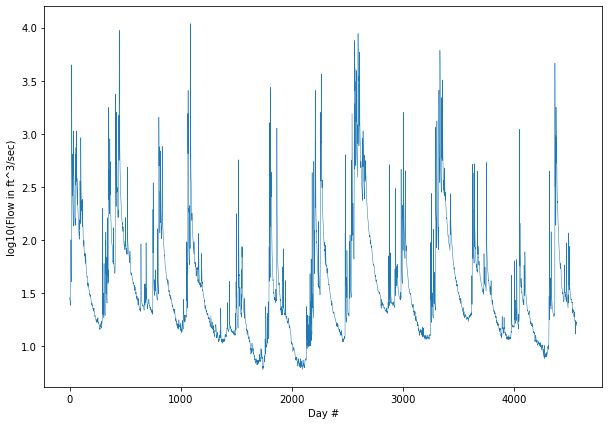

In [17]:
plt.figure(figsize=(10,7)) 
x=np.arange(len(gageDataDaily['Flow'].values))
y=gageDataDaily['Flow'].values
plt.plot(x,np.log10(y),linewidth=0.5)
plt.xlabel('Day #')
plt.ylabel('log10(Flow in ft^3/sec)')

#### Goal is to predict the stream flow at times (i) one hour, (ii) one day, (iii) one week, and (iv) one month into the future

Split data into training, validation, and test sets.

In [18]:
gageDataDaily = gageDataDaily.loc['2010-01-02 00:00:00': '2021-12-30 23:00:00']
end_train = '2017-12-31 23:59:00'
end_validation = '2019-11-30 23:59:00'
data_train = gageDataDaily.loc[: end_train, :]
data_val   = gageDataDaily.loc[end_train:end_validation, :]
data_test  = gageDataDaily.loc[end_validation:, :]

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}")

Train dates      : 2010-01-02 00:00:00+00:00 --- 2017-12-31 00:00:00+00:00
Validation dates : 2018-01-01 00:00:00+00:00 --- 2019-11-30 00:00:00+00:00
Test dates       : 2019-12-01 00:00:00+00:00 --- 2021-12-30 00:00:00+00:00


Plot the time series for the relevant variables

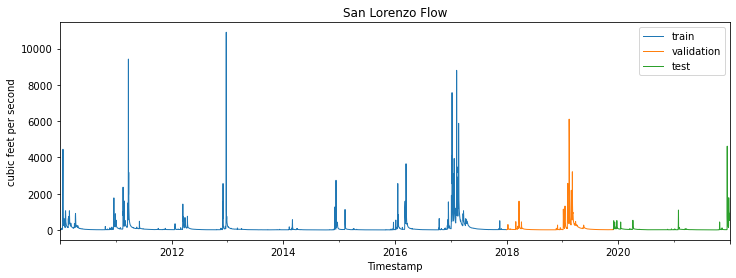

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
data_train.Flow.plot(ax=ax, label='train', linewidth=1)
data_val.Flow.plot(ax=ax, label='validation', linewidth=1)
data_test.Flow.plot(ax=ax, label='test', linewidth=1)
ax.set_title('San Lorenzo Flow')
ax.set_ylabel('cubic feet per second')
ax.legend();

Autocorrelation out to lags of more than a year

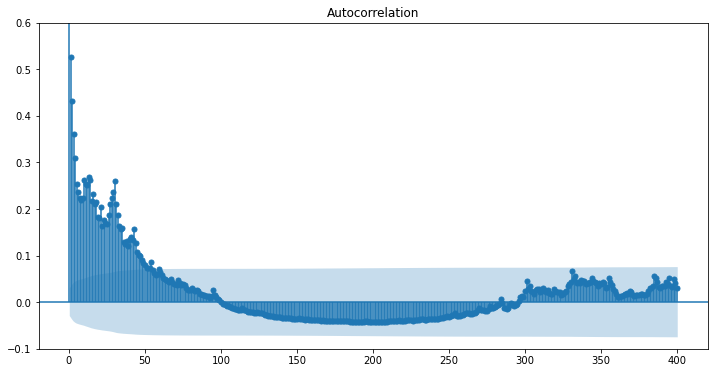

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(gageDataDaily.Flow, ax=ax, lags=400)
plt.ylim(-0.1,0.6)
plt.show()

In [50]:
# Create and train forecaster

forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 2
             )

forecaster.fit(y=gageDataDaily.loc[:end_validation, 'Flow'])
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [1 2] 
Window size: 2 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-02 00:00:00+0000', tz='UTC'), Timestamp('2019-11-30 00:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-07-01 15:27:25 
Last fit date: 2022-07-01 15:27:25 
Skforecast version: 0.4.3 

In [51]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = gageDataDaily.Flow,
                            initial_train_size = len(gageDataDaily.loc[:end_validation]),
                            fixed_train_size   = False,
                            steps      = 2,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                       )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 3620
Number of observations used for backtesting: 761
    Number of folds: 381
    Number of steps per fold: 2
    Last fold only includes 1 observations

Data partition in fold: 0
    Training:   2010-01-02 00:00:00+00:00 -- 2019-11-30 00:00:00+00:00
    Validation: 2019-12-01 00:00:00+00:00 -- 2019-12-02 00:00:00+00:00
Data partition in fold: 1
    Training:   2010-01-02 00:00:00+00:00 -- 2019-11-30 00:00:00+00:00
    Validation: 2019-12-03 00:00:00+00:00 -- 2019-12-04 00:00:00+00:00
Data partition in fold: 2
    Training:   2010-01-02 00:00:00+00:00 -- 2019-11-30 00:00:00+00:00
    Validation: 2019-12-05 00:00:00+00:00 -- 2019-12-06 00:00:00+00:00
Data partition in fold: 3
    Training:   2010-01-02 00:00:00+00:00 -- 2019-11-30 00:00:00+00:00
    Validation: 2019-12-07 00:00:00+00:00 -- 2019-12-08 00:00:00+00:00
Data partition in fold: 4
    Tr

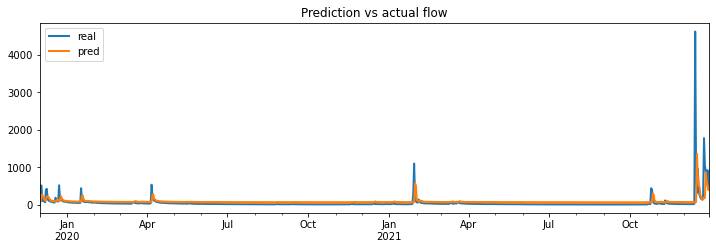

In [53]:
fig, ax = plt.subplots(figsize=(12, 3.5))
gageDataDaily.loc[predictions.index, 'Flow'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs actual flow')
#ax.set_ylim(0,500)
ax.legend();


In [66]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    lags      = 24 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [2, 3, 5, 10, 24, 48, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor's hyperparameters
param_grid = {'ridge__alpha': np.logspace(-3, 5, 10)}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = gageDataDaily.loc[:end_validation, 'Flow'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 2,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(gageDataDaily[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                 )

Number of models compared: 70


loop lags_grid: 100%|███████████████████████████████████████| 7/7 [00:18<00:00,  2.65s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'ridge__alpha': 0.001}
  Backtesting metric: 75.24798357237253



In [67]:
pd.set_option('display.max_rows', None)
results_grid

,lags,params,metric,ridge__alpha
40,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.001},75.247984,0.001000
41,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.007742636826811269},75.247998,0.007743
42,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.05994842503189409},75.248107,0.059948
43,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 0.46415888336127775},75.248950,0.464159
44,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 3.593813663804626},75.255469,3.593814
45,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 27.825594022071257},75.305420,27.825594
46,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 215.44346900318823},75.684312,215.443469
56,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'ridge__alpha': 215.44346900318823},78.586442,215.443469
60,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.001},78.588904,0.001000
61,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'ridge__alpha': 0.007742636826811269},78.588932,0.007743


Backtest model with best hyperparameters

In [68]:
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.001))]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-02 00:00:00+0000', tz='UTC'), Timestamp('2019-11-30 00:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 0.001, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-07-01 15:43:50 
Last fit date: 2022-07-01 15:44:09 
Skforecast version: 0.4.3 

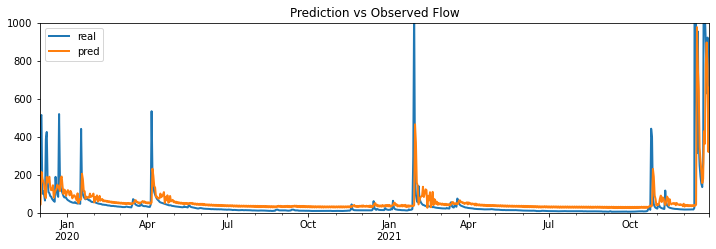

In [72]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = gageDataDaily.Flow,
                            initial_train_size = len(gageDataDaily[:end_validation]),
                            fixed_train_size   = False,
                            steps      = 2,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = False
                      )

fig, ax = plt.subplots(figsize=(12, 3.5))
gageDataDaily.loc[predictions.index, 'Flow'].plot(linewidth=2, label='real', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs Observed Flow')
ax.set_ylim(0,1000)
ax.legend();